**Notebook credit**: based on the F. Chollet's original notebook [here](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter04_getting-started-with-neural-networks.ipynb).

## Predicting house prices: A regression example

We have discussed _regression problems_ before
These consist of predicting a continuous value instead of a discrete label:
- predicting the temperature tomorrow, given meteorological data
- predicting the time that a software project will take to complete, given its specifications

However, we only discussed the linear regression case before where our predictions models were *linear*. Deep learning allows us to buil complex *non-linear* prediction models.

### The Boston Housing Price dataset

- we’ll predict the median price of homes in a given Boston suburb in the mid-1970s
- features of the suburb include things like the crime rate, the local property tax rate, and so on
- it has relatively few data points: only 506, split between 404 training samples and 102 test samples
- each feature in the input data (for example, the crime rate) has a different scale
  - some values are proportions, which take values between 0 and 1
  - others take values between 1 and 12
  - others between 0 and 100, and so on.

**Loading the Boston housing dataset**

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [ ]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


### Preparing the data

- widespread best practice is to do feature-wise normalization
- for each feature in the input data (a column in the input data matrix):
  - subtract the mean of the feature, and
  - divide by the standard deviation
- after this normalization, every feature is centered around 0 and has a unit standard deviation

**Normalizing the data**

In [ ]:
mean = train_data.mean(axis=0)

train_data -= mean

std = train_data.std(axis=0)

train_data /= std

test_data -= mean
test_data /= std

In [ ]:
train_data

array([[-0.27224633, -0.48361547, -0.43576161, ...,  1.14850044,
         0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, ..., -1.71818909,
         0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , ...,  0.78447637,
         0.22061726, -1.30850006],
       ...,
       [-0.40202987,  0.99079651, -0.7415148 , ..., -0.71712291,
         0.07943894, -0.67776904],
       [-0.17292018, -0.48361547,  1.24588095, ..., -1.71818909,
        -0.98764362,  0.42083466],
       [-0.40422614,  2.04394792, -1.20161456, ..., -1.30866202,
         0.23317118, -1.15392266]])

There is quite a bit of variation in the ranges that the 13 features lie in. The features themselves are described [here](http://lib.stat.cmu.edu/datasets/boston).

### Building your model

- because few samples are available, we'll use a very small model
- two intermediate layers, each with 64 units
- the less training data you have, the worse overfitting will be
- using a small model is one way to mitigate overfitting

**Model definition**

`"mse"` = mean squared error

`"mae"` = mean absolute error

### Exercise: Build you model with two intermediate layers, each with 64 units

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1) # linear regression corresponds to just having this layer
    ])
    # mse = 1 / n (\sum_i (yhat_i - y_i)^2)
    # mae = 1 / n (\sum_i|yhat_i - y_i|)
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Validating your approach using K-fold validation


- to select number of epochs used for training, we could split the data into a training set and a validation set, as we did in the IMDB example
- but we have so few data points
- validation set would end up being very small (e.g., about 100 examples
- validation scores might change a lot depending on which data points we chose for validation and which we chose for training
- the validation scores might have a high variance with regard to the validation split
- would prevent us from reliably evaluating our model.
- best practice in such situations is to use K-fold cross-validation (see figure 4.8)

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/k-fold.png" width="500">

**K-fold validation**

In [ ]:
k = 4

num_val_samples = len(train_data) // k  # note: integer division

num_epochs = 50 # don't know yet whether this is a good choice
all_scores = []

for i in range(k):
    print(f"Processing fold #{i}")
    # extract validation examples
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    # extract validation labels
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]

    # whatever is left after extraction becomes partial training data
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis=0
    )
    # partial training labels
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
         axis=0
    )    

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)                       # verbose=0 doesn't print anything while fitting
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


- different runs do indeed show rather different validation scores
- average validation score is a much more reliable metric than any single score
- how much are we off on average?
- is it significant? (recall that prices range from 5k to 50k)

**Saving the validation logs at each fold**

In [ ]:
num_epochs = 300 # increased this from 50 to 300
all_mae_histories = [] # will store entire mae history as opposed to a single score
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),                # we now use the validation_data argument
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]                                    # store the entire history of the validation mae values
    all_mae_histories.append(mae_history)

len(all_mae_histories) # is a list containing 4 lists, each containing the val_mae history for a fold

for i in range(9): # the val_mae will typically be quite high for early epochs
  mean = np.mean([x[i] for x in all_mae_histories]) # the average val_mae, over 4 folds, for epoch i
  print(f"{mean:.2f}", end = " ")

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
19.41 16.05 12.17 8.37 6.20 5.04 4.30 3.88 3.58 

**Building the history of successive mean K-fold validation scores**

In [ ]:
for i in range(9):
  mean = np.mean([x[i] for x in all_mae_histories])
  print(f"{mean:.2f}", end = " ")


19.41 16.05 12.17 8.37 6.20 5.04 4.30 3.88 3.58 

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories])
    for i in range(num_epochs)
]

**Plotting validation scores**

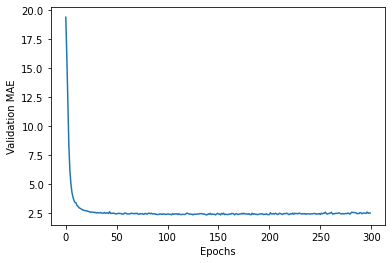

In [ ]:
plt.plot(range(len(average_mae_history)), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

- as we saw earlier, the first 10 data points have high validation MAE
- makes it a little difficult to read the plot
- let's replot after omitting the first 10 points

**Plotting validation scores, excluding the first 10 data points**

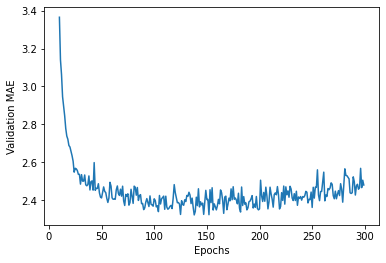

In [ ]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(10, len(average_mae_history)), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

- validation MAE stops improving significantly after 120–140 epochs
- past that point, we start *overfitting*


**Training the final model: Exercise**

- Here we only tuned number of epochs
- you could also adjust the size of the intermediate layers
- once you're finished tuning, you can train a final production model
- this will use _all_ of the training data
- it will use the best choices for tuning parameters (e.g., 130 for epochs in our case)
- you will evaluate its performance on the test data (that we haven't touched at all so far)

In [ ]:
model = build_model()
model.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)

In [ ]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 15.4580 - mae: 2.4768


### Generating predictions on new data